In [2]:
import stompy.model.delft.dflow_model as dfm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import xarray as xr
import ipywidgets as widgets

from stompy import xr_transect as xrt
import os
from stompy import utils
import stompy.plot.cmap as scmap
import numpy as np
%matplotlib notebook

In [3]:
import six
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/home/rustyh/src/stompy/stompy/model/delft/dflow_model.py'>

In [4]:
turbo=scmap.load_gradient('turbo.cpt')
hot_cold=scmap.load_gradient('hot_and_cold.cpt')

In [5]:
run_dirs=['data_2016long_3d_asbuilt_impaired-v001', # 50 layers no evap
          #'data_2016long_3d_asbuilt_impaired-v002', # 100 layers
          #'data_2016long_3d_asbuilt_impaired_scen1-v001', # 100 layers
          #'data_2016long_3d_asbuilt_impaired-v003', # default epshu, 50 layers
          #'data_2016long_3d_asbuilt_impaired-v004',# default epshu and 100 layers
          #'data_2016long_3d_asbuilt_impaired-v005',# copy of v001 with new DFM compile
          'data_short_v000', # should match v001?
          'data_short_v002', 
          'data_short_v003', 
          #'data_short_v005', 
          'data_short_v006',
          'data_short_v008', # leading candidate
          'data_short_v012', 
          #'data_short_v013', 
          'data_short_v015',
         ]

In [6]:
try:
    [h.close() for h in hiss]
except NameError:
    pass
his_fns=[os.path.join(d,'DFM_OUTPUT_flowfm/flowfm_0000_his.nc')
         for d in run_dirs]
hiss=[xr.open_dataset(his_fn) for his_fn in his_fns]
for his,d in zip(hiss,run_dirs):
    his.attrs['run_dir']=d

In [7]:
patt='thalweg_pesc.*'

trans=[dfm.extract_transect_his(his,patt) for his in hiss]

<IPython.core.display.Javascript object>


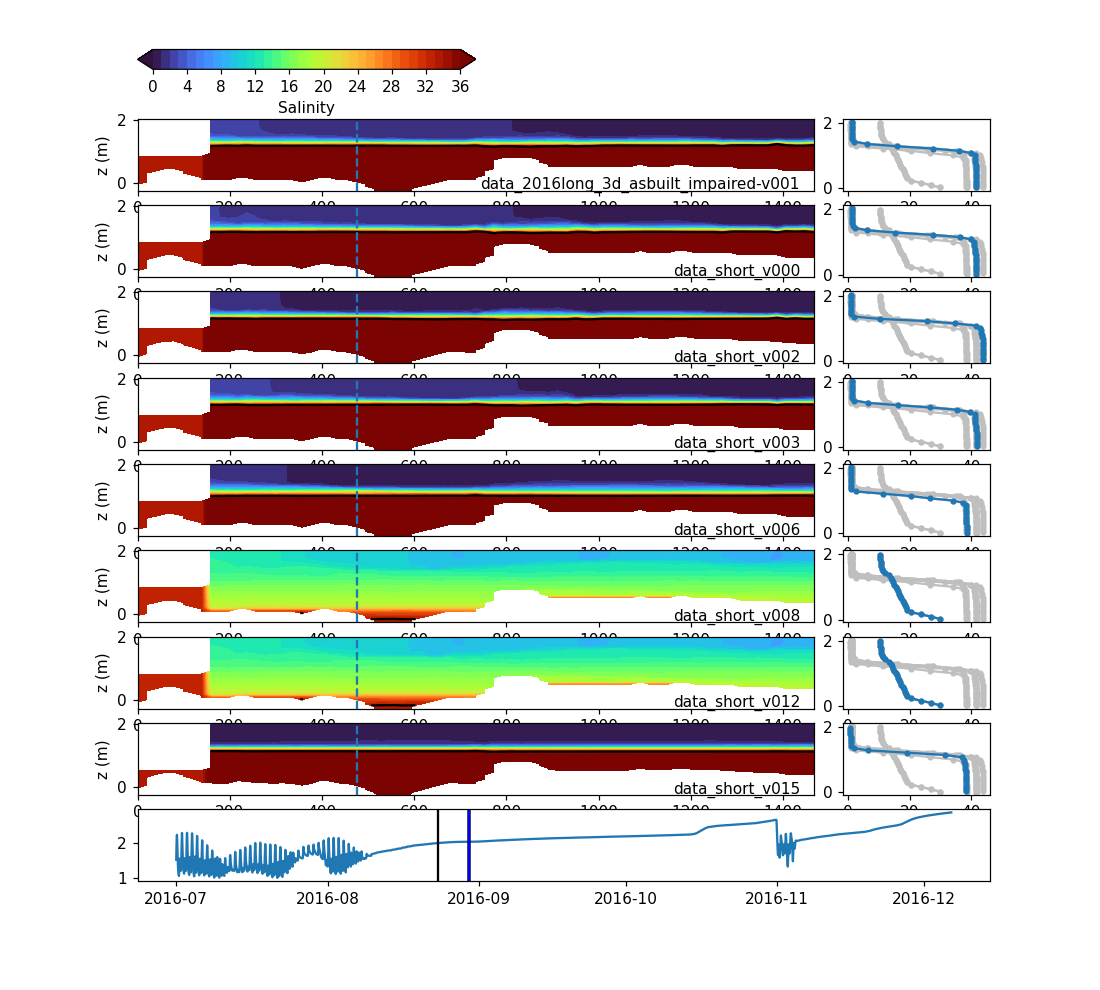

Range of salinity:  0.6187227638964055 46.38270726037233
Range of salinity:  0.6130398650789202 46.16869092561579
Range of salinity:  0.3757255007560881 51.07269867890319
Range of salinity:  0.6416515706352345 45.98613914918347
Range of salinity:  0.3587741621413662 39.03900192345802
Range of salinity:  7.905175968044203 33.68054266881731
Range of salinity:  7.905175968044203 33.68054266881731
Range of salinity:  0.11729523818352464 39.18847430355885


In [8]:
fig=plt.figure(figsize=(10,9))

G=gs.GridSpec(1+len(trans),5)

axs=[]
axv=ax=None
axvs=[]
for ti,t in enumerate(trans):
    ax=fig.add_subplot(G[ti,:-1],sharex=ax,sharey=ax)
    axs.append(ax)
    axv=fig.add_subplot(G[ti,-1],sharex=axv,sharey=axv)
    axvs.append(axv)

    
top_pos=axs[0].get_position()

cax=fig.add_axes( [top_pos.xmin,top_pos.ymax+0.05,0.5*top_pos.width,0.02])

t=np.datetime64("2016-08-29T23:00")
dist=475 # pull a profile from here.
#dist=185 # just inside mouth

V=np.linspace(0,36,37)

ttrans=[tran.isel(
        time=min(np.searchsorted(tran.time.values,t),
                 tran.dims['time']-1) )
     for tran in trans]
    

for ax,tran in zip(axs,ttrans):
    xrt.get_d_sample(tran)
    cset=xrt.contourf(tran,'salinity',V,ax=ax,cmap=turbo,extend='both')
    ax.set_ylabel('z (m)')
    xrt.contour(tran,'salinity',np.r_[33.0],ax=ax,colors='k')
    print("Range of salinity: ",float(tran['salinity'].min()),
          float(tran['salinity'].max()))

plt.colorbar(cset,cax=cax,label='Salinity',orientation='horizontal')

sampxy=None
for ax,axv,tran in zip(axs,axvs,ttrans):
    txy=np.c_[ tran.x_sample.values, tran.y_sample.values]
    if sampxy is None:
        samp=np.searchsorted(tran.d_sample.values,dist)
        sampxy=txy[samp]
    else:
        dists=utils.dist(sampxy, txy)
        samp=np.argmin(dists)
    axv.plot(tran['salinity'].isel(sample=samp),
             tran['z_ctr'].isel(sample=samp),
             marker='.')
    ax.axvline(tran.d_sample.values[samp],ls='--')
    ax.text(0.98,0.02,tran.attrs['run_dir'],transform=ax.transAxes,
            ha='right')
    # ghosted on other axes:
    for ax_other in axvs:
        if ax_other!=ax:
            ax_other.plot(tran['salinity'].isel(sample=samp),
                          tran['z_ctr'].isel(sample=samp),
                          color='0.75',marker='.',zorder=-1)
            

axt=fig.add_subplot(G[-1,:])
axt.plot( hiss[0].time, hiss[0]['waterlevel'].isel(stations=7),label='NCK waterlevel')

for tran in ttrans:
    axt.axvline( tran.time.values,color='k')
    
axt.axvline(t,color='b')

<IPython.core.display.Javascript object>


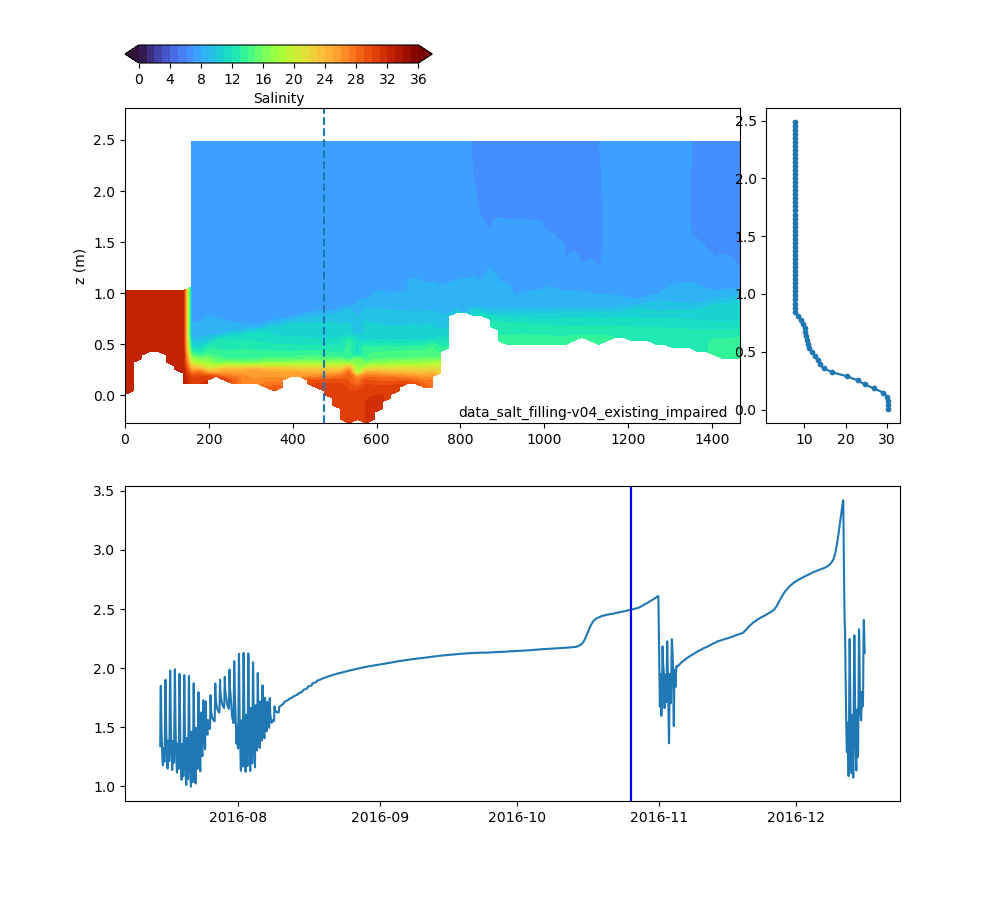

IntSlider(value=0, continuous_update=False, description='Time step:', layout=Layout(width='75%'), max=14784)

In [46]:
# How to animate those sections:
fig=plt.figure(figsize=(10,9))

G=gs.GridSpec(1+len(trans),5)

axs=[]
axv=ax=None
axvs=[]
for ti,t in enumerate(trans):
    ax=fig.add_subplot(G[ti,:-1],sharex=ax,sharey=ax)
    axs.append(ax)
    axv=fig.add_subplot(G[ti,-1],sharex=axv,sharey=axv)
    axvs.append(axv)
    ax.text(0.98,0.02,t.attrs['run_dir'],transform=ax.transAxes,
            ha='right')
    
top_pos=axs[0].get_position()

cax=fig.add_axes( [top_pos.xmin,top_pos.ymax+0.05,0.5*top_pos.width,0.02])
    
t=np.datetime64("2016-06-16T12:00")
#t=np.datetime64("2016-06-13T22:00")
#t=np.datetime64("2016-06-12T22:00")
dist=475 # pull a profile from here.
#dist=185 # just inside mouth

V=np.linspace(0,36,37)
axt=fig.add_subplot(G[-1,:])
axt.plot( hiss[0].time, hiss[0]['waterlevel'].isel(stations=7),label='NCK waterlevel')

def freeze(fig):
    return [ dict(collections=list(ax.collections),lines=list(ax.lines)) 
             for ax in fig.axes ]
def thaw(fig,state):
    for ax,ax_state in zip(fig.axes,state):
        for k in ax_state:
            setattr(ax,k,list(ax_state[k]))
frozen=freeze(fig)

def draw(t):
    thaw(fig,frozen)
    ttrans=[tran.isel(
            time=min(np.searchsorted(tran.time.values,t),
                     tran.dims['time']-1) )
         for tran in trans]


    for ax,tran in zip(axs,ttrans):
        xrt.get_d_sample(tran)
        cset=xrt.contourf(tran,'salinity',V,ax=ax,cmap=turbo,extend='both')
        ax.set_ylabel('z (m)')

    plt.colorbar(cset,cax=cax,label='Salinity',orientation='horizontal')

    sampxy=None
    for ax,axv,tran in zip(axs,axvs,ttrans):
        txy=np.c_[ tran.x_sample.values, tran.y_sample.values]
        if sampxy is None:
            samp=np.searchsorted(tran.d_sample.values,dist)
            sampxy=txy[samp]
        else:
            dists=utils.dist(sampxy, txy)
            samp=np.argmin(dists)
        axv.plot(tran['salinity'].isel(sample=samp),
                 tran['z_ctr'].isel(sample=samp),
                 marker='.',color='tab:Blue')
        ax.axvline(tran.d_sample.values[samp],ls='--')

        # ghosted on other axes:
        for ax_other in axvs:
            if ax_other!=ax:
                ax_other.plot(tran['salinity'].isel(sample=samp),
                              tran['z_ctr'].isel(sample=samp),
                              color='0.75',marker='.',zorder=-1)



    for tran in ttrans:
        axt.axvline( tran.time.values,color='k')

    axt.axvline(t,color='b')


import ipywidgets as widgets
slider=widgets.IntSlider(
    min=0,
    max=len(his.time)-1,
    step=1,
    description='Time step:',
    continuous_update=False,
    orientation='horizontal',
    layout=widgets.Layout(width='75%'),
)
slider.observe(lambda change: draw(his.time.values[change['new']]),
               names='value')
#draw(his.time.values[-1])
slider

In [11]:
model=dfm.DFlowModel.load(run_dirs[0])

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=temperaturebnd
Not implemented: reading BC quantity=discharge_salinity_temperature_sorsin
Not implemented: reading BC quantity=discharge_salinity_temperature_sorsin
Not implemented: reading BC quantity=rainfall_rate
Not implemented: reading BC quantity=windxy


<IPython.core.display.Javascript object>


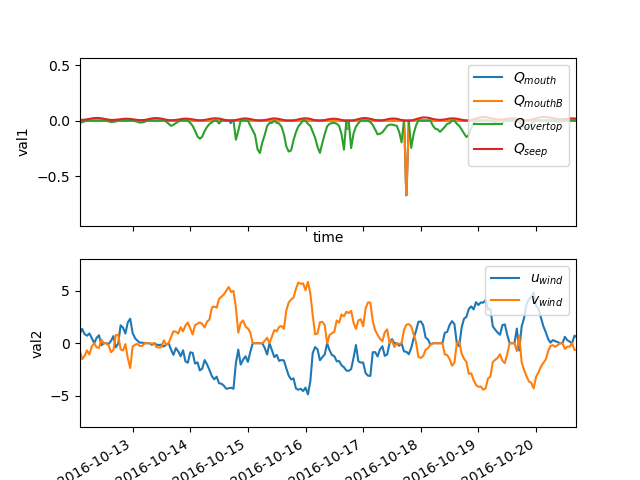

In [56]:
bcs=model.load_bcs()

# Minor flow in over the structures -- 10-16 17:00 and 10-17 17:00
# but it's small. 0.1 and 0.7 m3/s respectively.
fig,axs=plt.subplots(2,1,sharex=True)
his.general_structure_discharge.isel(general_structures=0).plot(ax=axs[0],label='$Q_{mouth}$')
his.general_structure_discharge.isel(general_structures=1).plot(ax=axs[0],label='$Q_{mouthB}$')

wind=model.read_tim(os.path.join(model.run_dir,'wind.tim'))
overtopping=model.read_tim(os.path.join(model.run_dir,'wave_overtop.tim'))
(-overtopping.val1).plot(ax=axs[0],label='$Q_{overtop}$')

seepage=model.read_tim(os.path.join(model.run_dir,'seepage.tim'))
seepage.val1.plot(ax=axs[0],label='$Q_{seep}$')

wind.val1.plot(ax=axs[1],label='$u_{wind}$')
wind.val2.plot(ax=axs[1],label='$v_{wind}$')
axs[0].axis((17086.087, 17094.693,  -0.9453, 0.5671))
axs[1].axis(ymin=-8,ymax=8)
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')


In [54]:
seepage

<xarray.Dataset>
Dimensions:  (time: 3699)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-14T23:00:00 ... 2016-12-16T01:00:00
Data variables:
    val1     (time) float64 0.0 0.0 0.0 0.0 ... 0.0042 0.006064 0.007744
    val2     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    val3     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Attributes:
    source:   data_salt_filling-v04_existing_impaired/seepage.tim

In [36]:
wind

<xarray.Dataset>
Dimensions:  (time: 3699)
Coordinates:
  * time     (time) datetime64[ns] 2016-07-14T23:00:00 ... 2016-12-16T01:00:00
Data variables:
    val1     (time) float64 1.079 1.436 1.086 0.7631 ... -5.787 -5.287 -5.053
    val2     (time) float64 0.1168 -0.4291 -0.2423 -0.1951 ... 6.646 6.439 6.578
Attributes:
    source:   data_salt_filling-v04_existing_impaired/wind.tim

In [11]:
from stompy.grid import multi_ugrid
mu=multi_ugrid.MultiUgrid(model.map_outputs())

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

<IPython.core.display.Javascript object>


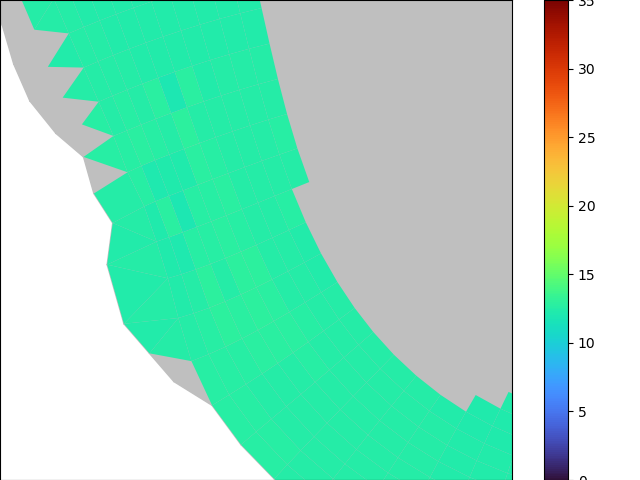

IntSlider(value=0, description='Layer:', max=99)

In [24]:
from matplotlib import colors
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.set_adjustable('datalim')
def draw(layer,ax=ax):
    ax.collections=[]
    mu.grid.plot_cells(color="0.75",zorder=-1,ax=ax)
    ccoll=mu.grid.plot_cells(values=mu.isel(time=50,mesh2d_nLayers=layer)['mesh2d_sa1'].values.clip(1),
                         cmap='turbo',ax=ax)
    ccoll.set_clim([0,35])
    return ccoll
ccoll=draw(10)
plt.colorbar(ccoll)

slider=widgets.IntSlider(
    min=0,
    max=mu.dims['mesh2d_nLayers']-1,
    step=1,
    description='Layer:',
    #continuous_update=False,
    #orientation='horizontal',
)
slider.observe(lambda change: draw(change['new']),
               names='value')
slider

In [13]:
mu['mesh2d_sa1']

MultiVar wrapper around <xarray.DataArray 'mesh2d_sa1' (time: 77, mesh2d_nFaces: 2875, mesh2d_nLayers: 100)>
[22137500 values with dtype=float64]
Coordinates:
    mesh2d_face_x  (mesh2d_nFaces) float64 5.526e+05 5.526e+05 ... 5.525e+05
    mesh2d_face_y  (mesh2d_nFaces) float64 4.124e+06 4.124e+06 ... 4.125e+06
  * time           (time) datetime64[ns] 2016-07-15 2016-07-17 ... 2016-12-14
Dimensions without coordinates: mesh2d_nFaces, mesh2d_nLayers
Attributes:
    mesh:           mesh2d
    location:       face
    cell_methods:   mesh2d_nFaces: mean
    standard_name:  sea_water_salinity
    long_name:      Salinity in flow element
    units:          1e-3
    grid_mapping:   projected_coordinate_system